# Julia + JuMP Battery Optimisation

In [1]:
using Dates
using Parquet
using DataFrames
using JuMP
using Gurobi
using Cbc
using HiGHS
using Plots
using StatsPlots
using Profile

## NSW Energy Prices Dec 2021

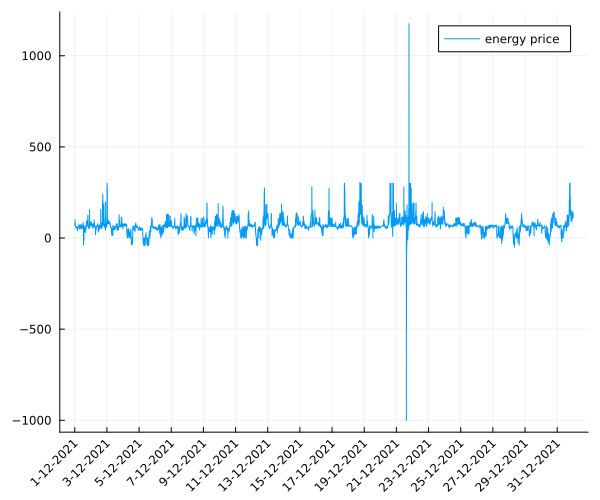

In [2]:
df = DataFrame(Parquet.read_parquet("../data/"))
df = df[(df.REGIONID .== "NSW1") .& (df.INTERVENTION .== 0), :]
df = rename(df, "RRP"=>"energy_price", "SETTLEMENTDATE"=>"datetime")
nsw_energy_prices = select(df, [:datetime, :energy_price])
nsw_energy_prices.datetime = DateTime.(nsw_energy_prices.datetime, dateformat"yyyy/mm/dd HH:MM:SS")
ticks = range(nsw_energy_prices.datetime[1], nsw_energy_prices.datetime[end], step=Day(2))
ticks_fmt = Dates.format.(ticks, "d-mm-yyyy")
plot(nsw_energy_prices[:, :datetime], nsw_energy_prices[:, :energy_price], 
     xticks=(ticks,ticks_fmt), xrot=45, size=(600, 500), label="energy price")

## Formulating the problem

### Mixed-integer bilinearly constrained problem

The formulation below is an intuitive formulation of the energy arbitrage problem that has bilinear terms (i.e. $q_tu_t$ or $p_tu_t$).

\begin{aligned}
\max_{t} \quad & \sum_{t}{\tau\lambda_t(p_t-q_t)}\\
\textrm{s.t.} \quad & 0 \leq p_t,q_t \leq \bar{p}\\
& u_t \in \{0,1\}    \\
& \underline{e} \leq e_t \leq \bar{e}    \\
& e_t-e_{t-1}- \left( q_t\eta_{charge}\tau\right)u_t+\frac{p_t\tau}{\eta_{discharge}}\left(1-u_t\right) = 0\\
\end{aligned}

where:
- $\tau=\frac{1}{12} \textrm{hours}$
- $p_t$ corresponds to MW discharge at time $t$
- $q_t$ corresponds to MW charge at time $t$
- $u_t=1$ indicates charging, $u_t=0$ indicates discharging (*charge state*)
- $\bar{p}$ corresponds to the max power capacity in MW
- $\underline{e}$ and $\bar{e}$ corresponds to minimum and maximum state-of-charge limits, respectively
- $\lambda_t$ corresponds to the energy price in $/MWh at time $t$
- $\eta$ corresponds to efficiency (one term for charging and one term for discharging)

### Mixed-integer linear problem

Solving the mixed-integer bilinearly constrained program would require a mixed-integer quadratically-constrained program (MIQCP) solver. 

However, we can adapt the formulation to simplify the problem into a mixed-integer linear program (MILP) with one binary variable:

\begin{aligned}
\max_{t} \quad & \sum_{t}{\tau\lambda_t(p_t-q_t)}\\
\textrm{s.t.} \quad & u_t \in \{0,1\}    \\
& p_t \geq 0 \\
& q_t \geq 0 \\
& p_t - \bar{p}\left(1-u_t\right) \leq 0\\
& q_t - \bar{p}u_t \leq 0\\
& \underline{e} \leq e_t \leq \bar{e}    \\
& e_t-e_{t-1}- \left( q_t\eta_{charge}\tau\right)+\frac{p_t\tau}{\eta_{discharge}} = 0\\
\end{aligned}


In [3]:
function create_jump_model(optimiser, energy_price_ts::DataFrame; silent::Bool=false)
    power_cap = 30  # MW
    energy_cap = 30  # MWh
    soc_lower_limit = 0.1 * energy_cap  # MWh
    soc_upper_limit = 0.9 * energy_cap  # MWh
    charge_eff = 0.9  # unitless
    discharge_eff = 0.9  # unitless
    τ = 5.0 / 60.0  # minutes per hour
    # initial conditions
    soc_mwh₀ = 0.5 * energy_cap # MWh
    
    times = range(1, length(energy_price_ts.datetime))
    
    model = Model(optimiser)
    
    # variables
    @variables(model, begin
        0.0 ≤ discharge_mw[t=times] ≤ power_cap
        0.0 ≤ charge_mw[t=times] ≤ power_cap
        charge_state[t=times], Bin
        soc_lower_limit ≤ soc_mwh[t=times] ≤ soc_upper_limit
    end)
    # constraints
    @constraints(model, begin
        discharge_operation[t=times], discharge_mw[t] - power_cap*(1-charge_state[t]) ≤ 0.0
        charge_operation[t=times], charge_mw[t] - power_cap * charge_state[t] ≤ 0.0
        intertemp_soc[t=times[2:end]], soc_mwh[t] - soc_mwh[t-1] - charge_mw[t]*charge_eff*τ + discharge_mw[t]*τ/discharge_eff == 0.0
        initial_soc, soc_mwh[1] == 0.5 * soc_mwh₀
    end)
    # objective
    @objective(model, Max, sum(energy_price_ts.energy_price[t]*τ*(discharge_mw[t]-charge_mw[t]) for t=times))
    if silent
        set_silent(model)
    end
    optimize!(model)
    return model
end 

create_jump_model (generic function with 1 method)

## Benchmarking

In Julia, the first run in each benchmark set will be slower as Julia will compile the code (notice high % compilation time) for JuMP (first run of Gurobi suite), but also the code for each of the Julia solver interfaces.

In [4]:
for loop in 1:10
    @time create_jump_model(Gurobi.Optimizer, nsw_energy_prices, silent=true)
end
gurobi_model = create_jump_model(Gurobi.Optimizer, nsw_energy_prices, silent=true);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
 10.404714 seconds (20.36 M allocations: 1.253 GiB, 4.28% gc time, 76.66% compilation time)
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
  2.336871 seconds (1.54 M allocations: 92.070 MiB)
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
  2.368253 seconds (1.54 M allocations: 92.070 MiB, 2.48% gc time)
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
  2.358341 seconds (1.57 M allocations: 93.360 MiB, 2.49% gc time, 0.63% compilation time)
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
  2.320935 seconds (1.54 M allocations: 92.070 MiB)
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
  2.417375 seconds (1.54 M allocations: 92.070 MiB, 4.33% gc time)
Set parameter Username
Academic l

In [5]:
for loop in 1:10
    @time create_jump_model(Cbc.Optimizer, nsw_energy_prices, silent=true);
end
cbc_model = create_jump_model(Cbc.Optimizer, nsw_energy_prices, silent=true);

 11.644744 seconds (18.95 M allocations: 1.091 GiB, 3.33% gc time, 57.13% compilation time)
  4.985070 seconds (1.23 M allocations: 102.773 MiB, 0.82% gc time)
  5.018806 seconds (1.23 M allocations: 102.773 MiB, 1.56% gc time)
  5.025756 seconds (1.23 M allocations: 102.773 MiB)
  4.970881 seconds (1.23 M allocations: 102.773 MiB)
  5.231916 seconds (1.23 M allocations: 102.774 MiB, 4.76% gc time, 0.07% compilation time)
  4.961133 seconds (1.23 M allocations: 102.773 MiB)
  5.018289 seconds (1.23 M allocations: 102.773 MiB, 0.44% gc time)
  4.975023 seconds (1.23 M allocations: 102.773 MiB, 0.51% gc time)
  5.019132 seconds (1.23 M allocations: 102.773 MiB, 0.57% gc time)


In [6]:
for loop in 1:10
    @time create_jump_model(HiGHS.Optimizer, nsw_energy_prices, silent=true);
end
highs_model = create_jump_model(HiGHS.Optimizer, nsw_energy_prices, silent=true);

 10.682885 seconds (6.21 M allocations: 390.672 MiB, 1.33% gc time, 23.02% compilation time)
  8.066814 seconds (1.43 M allocations: 120.889 MiB, 0.48% gc time)
  7.916921 seconds (1.43 M allocations: 120.889 MiB)
  8.062125 seconds (1.43 M allocations: 120.890 MiB, 0.50% gc time, 0.05% compilation time)
  8.085811 seconds (1.43 M allocations: 120.889 MiB, 0.47% gc time)
  8.189880 seconds (1.43 M allocations: 120.889 MiB, 0.45% gc time)
  8.442380 seconds (1.43 M allocations: 120.889 MiB, 0.45% gc time)
  8.297892 seconds (1.43 M allocations: 120.889 MiB)
  8.196113 seconds (1.43 M allocations: 120.889 MiB, 0.48% gc time)
  8.276901 seconds (1.43 M allocations: 120.889 MiB, 0.47% gc time)


## Solution

In [7]:
if termination_status(gurobi_model) == OPTIMAL
    println("gurobi:", objective_value(gurobi_model))
    println("highs:", objective_value(highs_model))
    println("cbc:", objective_value(cbc_model))
end

gurobi:171357.63973835483
highs:171363.9631105401
cbc:171363.9631105405


In [8]:
soln = DataFrame(
    Dict(
        sym => value.(highs_model[sym].data) for sym in (:discharge_mw, :charge_mw, :charge_state, :soc_mwh)
            )
)
soln[!, :datetime] = nsw_energy_prices.datetime
soln[!, :price] = nsw_energy_prices.energy_price
soln[(soln.charge_mw .> 0) .&& (soln.discharge_mw .> 0), :]

2×6 DataFrame
 Row │ charge_mw  charge_state  discharge_mw  soc_mwh  datetime             pr ⋯
     │ Float64    Float64       Float64       Float64  DateTime             Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   5.18519           1.0   3.06411e-14  3.38889  2021-12-05T11:25:00   - ⋯
   2 │  30.0               1.0   3.41747e-13  6.75     2021-12-28T07:50:00  -1
                                                                1 column omitted

In [9]:
p1 = @df soln scatter(:price, [:discharge_mw :charge_mw], labels=["discharge" "charge"], xlabel="Price (\$\$/MWh)", ylabel="MW")
vline!([0.0], color=:black, ls=:dash, label=nothing)

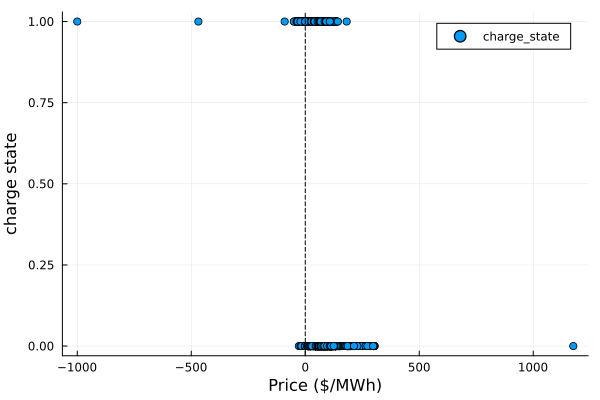

In [10]:
p2 = @df soln scatter(:price, [:charge_state], labels="charge_state", xlabel="Price (\$\$/MWh)", ylabel="charge state")
vline!([0.0], color=:black, ls=:dash, label=nothing)